In [119]:
# from google.colab import drive
# drive.mount('/content/drive')

In [120]:
import filter_method

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [122]:
path = ""

In [123]:
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
y_train = pd.read_pickle("y_train.pkl")
y_test = pd.read_pickle("y_test.pkl")

In [124]:
# check same length of samples and labels
# train
assert X_train.shape[0] == y_train.shape[0]
# test
assert X_test.shape[0] == y_test.shape[0]

# check same features
assert X_train.shape[1] == X_test.shape[1]

In [125]:
X_train.head()

,joke_x,ambiguous_words,joke_tokenized,best_score_similarity_words,antonyms,longest_word,speical_chars,MEAN_CHARACTERS_PER_WORD(joke),UNIVERSAL_SENTENCE_ENCODER(joke)[0],UNIVERSAL_SENTENCE_ENCODER(joke)[1],UNIVERSAL_SENTENCE_ENCODER(joke)[2],UNIVERSAL_SENTENCE_ENCODER(joke)[3],UNIVERSAL_SENTENCE_ENCODER(joke)[4],UNIVERSAL_SENTENCE_ENCODER(joke)[5],UNIVERSAL_SENTENCE_ENCODER(joke)[6],UNIVERSAL_SENTENCE_ENCODER(joke)[7],UNIVERSAL_SENTENCE_ENCODER(joke)[8],UNIVERSAL_SENTENCE_ENCODER(joke)[9],UNIVERSAL_SENTENCE_ENCODER(joke)[10],UNIVERSAL_SENTENCE_ENCODER(joke)[11],UNIVERSAL_SENTENCE_ENCODER(joke)[12],UNIVERSAL_SENTENCE_ENCODER(joke)[13],UNIVERSAL_SENTENCE_ENCODER(joke)[14],UNIVERSAL_SENTENCE_ENCODER(joke)[15],UNIVERSAL_SENTENCE_ENCODER(joke)[16],UNIVERSAL_SENTENCE_ENCODER(joke)[17],UNIVERSAL_SENTENCE_ENCODER(joke)[18],UNIVERSAL_SENTENCE_ENCODER(joke)[19],UNIVERSAL_SENTENCE_ENCODER(joke)[20],UNIVERSAL_SENTENCE_ENCODER(joke)[21],UNIVERSAL_SENTENCE_ENCODER(joke)[22],UNIVERSAL_SENTENCE_ENCODER(joke)[23],UNIVERSAL_SENTENCE_ENCODER(joke)[24],UNIVERSAL_SENTENCE_ENCODER(joke)[25],UNIVERSAL_SENTENCE_ENCODER(joke)[26],UNIVERSAL_SENTENCE_ENCODER(joke)[27],UNIVERSAL_SENTENCE_ENCODER(joke)[28],UNIVERSAL_SENTENCE_ENCODER(joke)[29],UNIVERSAL_SENTENCE_ENCODER(joke)[30],UNIVERSAL_SENTENCE_ENCODER(joke)[31],UNIVERSAL_SENTENCE_ENCODER(joke)[32],UNIVERSAL_SENTENCE_ENCODER(joke)[33],UNIVERSAL_SENTENCE_ENCODER(joke)[34],UNIVERSAL_SENTENCE_ENCODER(joke)[35],UNIVERSAL_SENTENCE_ENCODER(joke)[36],UNIVERSAL_SENTENCE_ENCODER(joke)[37],UNIVERSAL_SENTENCE_ENCODER(joke)[38],UNIVERSAL_SENTENCE_ENCODER(joke)[39],UNIVERSAL_SENTENCE_ENCODER(joke)[40],UNIVERSAL_SENTENCE_ENCODER(joke)[41],UNIVERSAL_SENTENCE_ENCODER(joke)[42],UNIVERSAL_SENTENCE_ENCODER(joke)[43],UNIVERSAL_SENTENCE_ENCODER(joke)[44],UNIVERSAL_SENTENCE_ENCODER(joke)[45],UNIVERSAL_SENTENCE_ENCODER(joke)[46],UNIVERSAL_SENTENCE_ENCODER(joke)[47],UNIVERSAL_SENTENCE_ENCODER(joke)[48],UNIVERSAL_SENTENCE_ENCODER(joke)[49],UNIVERSAL_SENTENCE_ENCODER(joke)[50],UNIVERSAL_SENTENCE_ENCODER(joke)[51],UNIVERSAL_SENTENCE_ENCODER(joke)[52],UNIVERSAL_SENTENCE_ENCODER(joke)[53],UNIVERSAL_SENTENCE_ENCODER(joke)[54],UNIVERSAL_SENTENCE_ENCODER(joke)[55],UNIVERSAL_SENTENCE_ENCODER(joke)[56],UNIVERSAL_SENTENCE_ENCODER(joke)[57],UNIVERSAL_SENTENCE_ENCODER(joke)[58],UNIVERSAL_SENTENCE_ENCODER(joke)[59],UNIVERSAL_SENTENCE_ENCODER(joke)[60],UNIVERSAL_SENTENCE_ENCODER(joke)[61],UNIVERSAL_SENTENCE_ENCODER(joke)[62],UNIVERSAL_SENTENCE_ENCODER(joke)[63],UNIVERSAL_SENTENCE_ENCODER(joke)[64],UNIVERSAL_SENTENCE_ENCODER(joke)[65],UNIVERSAL_SENTENCE_ENCODER(joke)[66],UNIVERSAL_SENTENCE_ENCODER(joke)[67],UNIVERSAL_SENTENCE_ENCODER(joke)[68],UNIVERSAL_SENTENCE_ENCODER(joke)[69],UNIVERSAL_SENTENCE_ENCODER(joke)[70],UNIVERSAL_SENTENCE_ENCODER(joke)[71],UNIVERSAL_SENTENCE_ENCODER(joke)[72],UNIVERSAL_SENTENCE_ENCODER(joke)[73],UNIVERSAL_SENTENCE_ENCODER(joke)[74],UNIVERSAL_SENTENCE_ENCODER(joke)[75],UNIVERSAL_SENTENCE_ENCODER(joke)[76],UNIVERSAL_SENTENCE_ENCODER(joke)[77],UNIVERSAL_SENTENCE_ENCODER(joke)[78],UNIVERSAL_SENTENCE_ENCODER(joke)[79],UNIVERSAL_SENTENCE_ENCODER(joke)[80],UNIVERSAL_SENTENCE_ENCODER(joke)[81],UNIVERSAL_SENTENCE_ENCODER(joke)[82],UNIVERSAL_SENTENCE_ENCODER(joke)[83],UNIVERSAL_SENTENCE_ENCODER(joke)[84],UNIVERSAL_SENTENCE_ENCODER(joke)[85],UNIVERSAL_SENTENCE_ENCODER(joke)[86],UNIVERSAL_SENTENCE_ENCODER(joke)[87],UNIVERSAL_SENTENCE_ENCODER(joke)[88],UNIVERSAL_SENTENCE_ENCODER(joke)[89],UNIVERSAL_SENTENCE_ENCODER(joke)[90],UNIVERSAL_SENTENCE_ENCODER(joke)[91],UNIVERSAL_SENTENCE_ENCODER(joke)[92],UNIVERSAL_SENTENCE_ENCODER(joke)[93],UNIVERSAL_SENTENCE_ENCODER(joke)[94],UNIVERSAL_SENTENCE_ENCODER(joke)[95],UNIVERSAL_SENTENCE_ENCODER(joke)[96],UNIVERSAL_SENTENCE_ENCODER(joke)[97],UNIVERSAL_SENTENCE_ENCODER(joke)[98],UNIVERSAL_SENTENCE_ENCODER(joke)[99],UNIVERSAL_SENTENCE_ENCODER(joke)[100],UNIVERSAL_SENTENCE_ENCODER(joke)[101],UNIVERSAL_SENTENCE_ENCODER(joke)[102],UNIVERSAL_SENTENCE_ENCODER(joke)[103],UNIVERSAL_SENTENCE_ENCOD

In [126]:
del X_train['joke_x']
del X_train['joke_tokenized']
del X_train['joke_text_processed']
del X_train['joke_processed_tokenized']
del X_train['joke_processed_tokenized_stemmed']
del X_train['joke_processed_tokenized_stemmed_str']
# del X_train['joke_embbedings']
del X_test['joke_x']
del X_test['joke_tokenized']
del X_test['joke_text_processed']
del X_test['joke_processed_tokenized']
del X_test['joke_processed_tokenized_stemmed']
del X_test['joke_processed_tokenized_stemmed_str']
# del X_test['joke_embbedings']

In [127]:
# Remove skew
def remove_skew_95(X,y,mean = None,std = None):
    if not mean:
        mean = y.mean()
    if not std:
        std = y.std()
    X = X[(y > (mean-2*std)) & (y < (mean+2*std))]
    y = y[(y > (mean-2*std)) & (y < (mean+2*std))]
    return X,y

In [128]:
mean = y_train.mean()
std = y_train.std()

In [129]:
X_train,y_train = remove_skew_95(X_train,y_train,mean,std)
X_test,y_test = remove_skew_95(X_test,y_test,mean,std)

In [130]:
X_train

,ambiguous_words,best_score_similarity_words,antonyms,longest_word,speical_chars,MEAN_CHARACTERS_PER_WORD(joke),UNIVERSAL_SENTENCE_ENCODER(joke)[0],UNIVERSAL_SENTENCE_ENCODER(joke)[1],UNIVERSAL_SENTENCE_ENCODER(joke)[2],UNIVERSAL_SENTENCE_ENCODER(joke)[3],UNIVERSAL_SENTENCE_ENCODER(joke)[4],UNIVERSAL_SENTENCE_ENCODER(joke)[5],UNIVERSAL_SENTENCE_ENCODER(joke)[6],UNIVERSAL_SENTENCE_ENCODER(joke)[7],UNIVERSAL_SENTENCE_ENCODER(joke)[8],UNIVERSAL_SENTENCE_ENCODER(joke)[9],UNIVERSAL_SENTENCE_ENCODER(joke)[10],UNIVERSAL_SENTENCE_ENCODER(joke)[11],UNIVERSAL_SENTENCE_ENCODER(joke)[12],UNIVERSAL_SENTENCE_ENCODER(joke)[13],UNIVERSAL_SENTENCE_ENCODER(joke)[14],UNIVERSAL_SENTENCE_ENCODER(joke)[15],UNIVERSAL_SENTENCE_ENCODER(joke)[16],UNIVERSAL_SENTENCE_ENCODER(joke)[17],UNIVERSAL_SENTENCE_ENCODER(joke)[18],UNIVERSAL_SENTENCE_ENCODER(joke)[19],UNIVERSAL_SENTENCE_ENCODER(joke)[20],UNIVERSAL_SENTENCE_ENCODER(joke)[21],UNIVERSAL_SENTENCE_ENCODER(joke)[22],UNIVERSAL_SENTENCE_ENCODER(joke)[23],UNIVERSAL_SENTENCE_ENCODER(joke)[24],UNIVERSAL_SENTENCE_ENCODER(joke)[25],UNIVERSAL_SENTENCE_ENCODER(joke)[26],UNIVERSAL_SENTENCE_ENCODER(joke)[27],UNIVERSAL_SENTENCE_ENCODER(joke)[28],UNIVERSAL_SENTENCE_ENCODER(joke)[29],UNIVERSAL_SENTENCE_ENCODER(joke)[30],UNIVERSAL_SENTENCE_ENCODER(joke)[31],UNIVERSAL_SENTENCE_ENCODER(joke)[32],UNIVERSAL_SENTENCE_ENCODER(joke)[33],UNIVERSAL_SENTENCE_ENCODER(joke)[34],UNIVERSAL_SENTENCE_ENCODER(joke)[35],UNIVERSAL_SENTENCE_ENCODER(joke)[36],UNIVERSAL_SENTENCE_ENCODER(joke)[37],UNIVERSAL_SENTENCE_ENCODER(joke)[38],UNIVERSAL_SENTENCE_ENCODER(joke)[39],UNIVERSAL_SENTENCE_ENCODER(joke)[40],UNIVERSAL_SENTENCE_ENCODER(joke)[41],UNIVERSAL_SENTENCE_ENCODER(joke)[42],UNIVERSAL_SENTENCE_ENCODER(joke)[43],UNIVERSAL_SENTENCE_ENCODER(joke)[44],UNIVERSAL_SENTENCE_ENCODER(joke)[45],UNIVERSAL_SENTENCE_ENCODER(joke)[46],UNIVERSAL_SENTENCE_ENCODER(joke)[47],UNIVERSAL_SENTENCE_ENCODER(joke)[48],UNIVERSAL_SENTENCE_ENCODER(joke)[49],UNIVERSAL_SENTENCE_ENCODER(joke)[50],UNIVERSAL_SENTENCE_ENCODER(joke)[51],UNIVERSAL_SENTENCE_ENCODER(joke)[52],UNIVERSAL_SENTENCE_ENCODER(joke)[53],UNIVERSAL_SENTENCE_ENCODER(joke)[54],UNIVERSAL_SENTENCE_ENCODER(joke)[55],UNIVERSAL_SENTENCE_ENCODER(joke)[56],UNIVERSAL_SENTENCE_ENCODER(joke)[57],UNIVERSAL_SENTENCE_ENCODER(joke)[58],UNIVERSAL_SENTENCE_ENCODER(joke)[59],UNIVERSAL_SENTENCE_ENCODER(joke)[60],UNIVERSAL_SENTENCE_ENCODER(joke)[61],UNIVERSAL_SENTENCE_ENCODER(joke)[62],UNIVERSAL_SENTENCE_ENCODER(joke)[63],UNIVERSAL_SENTENCE_ENCODER(joke)[64],UNIVERSAL_SENTENCE_ENCODER(joke)[65],UNIVERSAL_SENTENCE_ENCODER(joke)[66],UNIVERSAL_SENTENCE_ENCODER(joke)[67],UNIVERSAL_SENTENCE_ENCODER(joke)[68],UNIVERSAL_SENTENCE_ENCODER(joke)[69],UNIVERSAL_SENTENCE_ENCODER(joke)[70],UNIVERSAL_SENTENCE_ENCODER(joke)[71],UNIVERSAL_SENTENCE_ENCODER(joke)[72],UNIVERSAL_SENTENCE_ENCODER(joke)[73],UNIVERSAL_SENTENCE_ENCODER(joke)[74],UNIVERSAL_SENTENCE_ENCODER(joke)[75],UNIVERSAL_SENTENCE_ENCODER(joke)[76],UNIVERSAL_SENTENCE_ENCODER(joke)[77],UNIVERSAL_SENTENCE_ENCODER(joke)[78],UNIVERSAL_SENTENCE_ENCODER(joke)[79],UNIVERSAL_SENTENCE_ENCODER(joke)[80],UNIVERSAL_SENTENCE_ENCODER(joke)[81],UNIVERSAL_SENTENCE_ENCODER(joke)[82],UNIVERSAL_SENTENCE_ENCODER(joke)[83],UNIVERSAL_SENTENCE_ENCODER(joke)[84],UNIVERSAL_SENTENCE_ENCODER(joke)[85],UNIVERSAL_SENTENCE_ENCODER(joke)[86],UNIVERSAL_SENTENCE_ENCODER(joke)[87],UNIVERSAL_SENTENCE_ENCODER(joke)[88],UNIVERSAL_SENTENCE_ENCODER(joke)[89],UNIVERSAL_SENTENCE_ENCODER(joke)[90],UNIVERSAL_SENTENCE_ENCODER(joke)[91],UNIVERSAL_SENTENCE_ENCODER(joke)[92],UNIVERSAL_SENTENCE_ENCODER(joke)[93],UNIVERSAL_SENTENCE_ENCODER(joke)[94],UNIVERSAL_SENTENCE_ENCODER(joke)[95],UNIVERSAL_SENTENCE_ENCODER(joke)[96],UNIVERSAL_SENTENCE_ENCODER(joke)[97],UNIVERSAL_SENTENCE_ENCODER(joke)[98],UNIVERSAL_SENTENCE_ENCODER(joke)[99],UNIVERSAL_SENTENCE_ENCODER(joke)[100],UNIVERSAL_SENTENCE_ENCODER(joke)[101],UNIVERSAL_SENTENCE_ENCODER(joke)[102],UNIVERSAL_SENTENCE_ENCODER(joke)[103],UNIVERSAL_SENTENCE_ENCODER(joke)[104],UNIVERSA

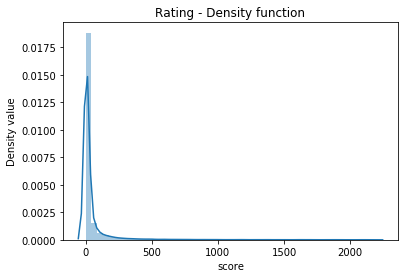

In [131]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [132]:
X_train.isna().sum().sum()

0

In [133]:
X_test.isna().sum().sum()

0

In [134]:
y_train = np.log(y_train)
y_test = np.log(y_test)

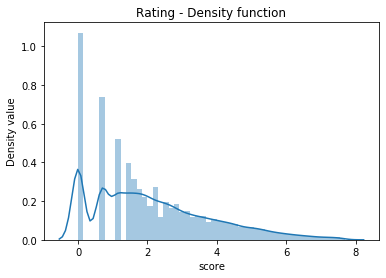

In [135]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [136]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_chars']])
X_train['total_chars'] = scaler.transform(X_train[['total_chars']])
X_test['total_chars'] = scaler.transform(X_test[['total_chars']])

In [137]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_words']])
X_train['total_words'] = scaler.transform(X_train[['total_words']])
X_test['total_words'] = scaler.transform(X_test[['total_words']])

In [138]:
# Remove skew
def remove_skew_95(X,y,mean = None,std = None):
    if not mean:
        mean = y.mean()
    if not std:
        std = y.std()
    X = X[(y > (mean-2*std)) & (y < (mean+2*std))]
    y = y[(y > (mean-2*std)) & (y < (mean+2*std))]
    return X,y

In [139]:
mean = y_train.mean()
std = y_train.std()

In [140]:
X_train,y_train = remove_skew_95(X_train,y_train,mean,std)
X_test,y_test = remove_skew_95(X_test,y_test,mean,std)

In [164]:
X_train.head()

,ambiguous_words,best_score_similarity_words,antonyms,longest_word,speical_chars,MEAN_CHARACTERS_PER_WORD(joke),UNIVERSAL_SENTENCE_ENCODER(joke)[0],UNIVERSAL_SENTENCE_ENCODER(joke)[1],UNIVERSAL_SENTENCE_ENCODER(joke)[2],UNIVERSAL_SENTENCE_ENCODER(joke)[3],UNIVERSAL_SENTENCE_ENCODER(joke)[4],UNIVERSAL_SENTENCE_ENCODER(joke)[5],UNIVERSAL_SENTENCE_ENCODER(joke)[6],UNIVERSAL_SENTENCE_ENCODER(joke)[7],UNIVERSAL_SENTENCE_ENCODER(joke)[8],UNIVERSAL_SENTENCE_ENCODER(joke)[9],UNIVERSAL_SENTENCE_ENCODER(joke)[10],UNIVERSAL_SENTENCE_ENCODER(joke)[11],UNIVERSAL_SENTENCE_ENCODER(joke)[12],UNIVERSAL_SENTENCE_ENCODER(joke)[13],UNIVERSAL_SENTENCE_ENCODER(joke)[14],UNIVERSAL_SENTENCE_ENCODER(joke)[15],UNIVERSAL_SENTENCE_ENCODER(joke)[16],UNIVERSAL_SENTENCE_ENCODER(joke)[17],UNIVERSAL_SENTENCE_ENCODER(joke)[18],UNIVERSAL_SENTENCE_ENCODER(joke)[19],UNIVERSAL_SENTENCE_ENCODER(joke)[20],UNIVERSAL_SENTENCE_ENCODER(joke)[21],UNIVERSAL_SENTENCE_ENCODER(joke)[22],UNIVERSAL_SENTENCE_ENCODER(joke)[23],UNIVERSAL_SENTENCE_ENCODER(joke)[24],UNIVERSAL_SENTENCE_ENCODER(joke)[25],UNIVERSAL_SENTENCE_ENCODER(joke)[26],UNIVERSAL_SENTENCE_ENCODER(joke)[27],UNIVERSAL_SENTENCE_ENCODER(joke)[28],UNIVERSAL_SENTENCE_ENCODER(joke)[29],UNIVERSAL_SENTENCE_ENCODER(joke)[30],UNIVERSAL_SENTENCE_ENCODER(joke)[31],UNIVERSAL_SENTENCE_ENCODER(joke)[32],UNIVERSAL_SENTENCE_ENCODER(joke)[33],UNIVERSAL_SENTENCE_ENCODER(joke)[34],UNIVERSAL_SENTENCE_ENCODER(joke)[35],UNIVERSAL_SENTENCE_ENCODER(joke)[36],UNIVERSAL_SENTENCE_ENCODER(joke)[37],UNIVERSAL_SENTENCE_ENCODER(joke)[38],UNIVERSAL_SENTENCE_ENCODER(joke)[39],UNIVERSAL_SENTENCE_ENCODER(joke)[40],UNIVERSAL_SENTENCE_ENCODER(joke)[41],UNIVERSAL_SENTENCE_ENCODER(joke)[42],UNIVERSAL_SENTENCE_ENCODER(joke)[43],UNIVERSAL_SENTENCE_ENCODER(joke)[44],UNIVERSAL_SENTENCE_ENCODER(joke)[45],UNIVERSAL_SENTENCE_ENCODER(joke)[46],UNIVERSAL_SENTENCE_ENCODER(joke)[47],UNIVERSAL_SENTENCE_ENCODER(joke)[48],UNIVERSAL_SENTENCE_ENCODER(joke)[49],UNIVERSAL_SENTENCE_ENCODER(joke)[50],UNIVERSAL_SENTENCE_ENCODER(joke)[51],UNIVERSAL_SENTENCE_ENCODER(joke)[52],UNIVERSAL_SENTENCE_ENCODER(joke)[53],UNIVERSAL_SENTENCE_ENCODER(joke)[54],UNIVERSAL_SENTENCE_ENCODER(joke)[55],UNIVERSAL_SENTENCE_ENCODER(joke)[56],UNIVERSAL_SENTENCE_ENCODER(joke)[57],UNIVERSAL_SENTENCE_ENCODER(joke)[58],UNIVERSAL_SENTENCE_ENCODER(joke)[59],UNIVERSAL_SENTENCE_ENCODER(joke)[60],UNIVERSAL_SENTENCE_ENCODER(joke)[61],UNIVERSAL_SENTENCE_ENCODER(joke)[62],UNIVERSAL_SENTENCE_ENCODER(joke)[63],UNIVERSAL_SENTENCE_ENCODER(joke)[64],UNIVERSAL_SENTENCE_ENCODER(joke)[65],UNIVERSAL_SENTENCE_ENCODER(joke)[66],UNIVERSAL_SENTENCE_ENCODER(joke)[67],UNIVERSAL_SENTENCE_ENCODER(joke)[68],UNIVERSAL_SENTENCE_ENCODER(joke)[69],UNIVERSAL_SENTENCE_ENCODER(joke)[70],UNIVERSAL_SENTENCE_ENCODER(joke)[71],UNIVERSAL_SENTENCE_ENCODER(joke)[72],UNIVERSAL_SENTENCE_ENCODER(joke)[73],UNIVERSAL_SENTENCE_ENCODER(joke)[74],UNIVERSAL_SENTENCE_ENCODER(joke)[75],UNIVERSAL_SENTENCE_ENCODER(joke)[76],UNIVERSAL_SENTENCE_ENCODER(joke)[77],UNIVERSAL_SENTENCE_ENCODER(joke)[78],UNIVERSAL_SENTENCE_ENCODER(joke)[79],UNIVERSAL_SENTENCE_ENCODER(joke)[80],UNIVERSAL_SENTENCE_ENCODER(joke)[81],UNIVERSAL_SENTENCE_ENCODER(joke)[82],UNIVERSAL_SENTENCE_ENCODER(joke)[83],UNIVERSAL_SENTENCE_ENCODER(joke)[84],UNIVERSAL_SENTENCE_ENCODER(joke)[85],UNIVERSAL_SENTENCE_ENCODER(joke)[86],UNIVERSAL_SENTENCE_ENCODER(joke)[87],UNIVERSAL_SENTENCE_ENCODER(joke)[88],UNIVERSAL_SENTENCE_ENCODER(joke)[89],UNIVERSAL_SENTENCE_ENCODER(joke)[90],UNIVERSAL_SENTENCE_ENCODER(joke)[91],UNIVERSAL_SENTENCE_ENCODER(joke)[92],UNIVERSAL_SENTENCE_ENCODER(joke)[93],UNIVERSAL_SENTENCE_ENCODER(joke)[94],UNIVERSAL_SENTENCE_ENCODER(joke)[95],UNIVERSAL_SENTENCE_ENCODER(joke)[96],UNIVERSAL_SENTENCE_ENCODER(joke)[97],UNIVERSAL_SENTENCE_ENCODER(joke)[98],UNIVERSAL_SENTENCE_ENCODER(joke)[99],UNIVERSAL_SENTENCE_ENCODER(joke)[100],UNIVERSAL_SENTENCE_ENCODER(joke)[101],UNIVERSAL_SENTENCE_ENCODER(joke)[102],UNIVERSAL_SENTENCE_ENCODER(joke)[103],UNIVERSAL_SENTENCE_ENCODER(joke)[104],UNIVERSA

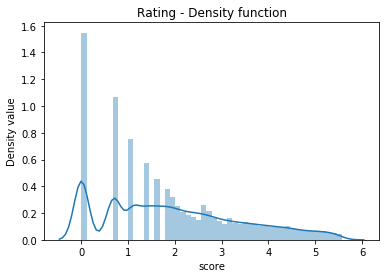

In [142]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [143]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_chars']])
X_train['total_chars'] = scaler.transform(X_train[['total_chars']])
X_test['total_chars'] = scaler.transform(X_test[['total_chars']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [144]:
scaler = MinMaxScaler()
scaler.fit(X_train[['total_words']])
X_train['total_words'] = scaler.transform(X_train[['total_words']])
X_test['total_words'] = scaler.transform(X_test[['total_words']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
def check_missing_data(df):
  """ 
      params: dataframe
      return: data of missing values, if have some.
  """
  flag=df.isna().sum().any()
  if flag==True:
      total = df.isnull().sum()
      percent = (df.isnull().sum())*100/(df.isnull().count())
      output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
      data_type = []
      for col in df.columns:
          dtype = str(df[col].dtype)
          data_type.append(dtype)
      output['Types'] = data_type
      return(output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
  else:
      return(False)

In [146]:
missing_X_train = check_missing_data(X_train)
missing_X_train

False

In [147]:
missing_X_test = check_missing_data(X_test)
missing_X_test

False

In [148]:
numerical_columns = X_train.select_dtypes(include=["int64", "float64"]).columns

In [149]:
X_train[pd.Index(numerical_columns)].shape

(74445, 1049)

In [150]:
X_train_num = X_train[pd.Index(set(numerical_columns))]
X_test_num = X_test[pd.Index(set(numerical_columns))]

In [153]:

model = ExtraTreesRegressor(n_estimators=2)
model.fit(X_train_num, y_train)

select_features_model = SelectFromModel(model, prefit=True) 

In [154]:
bool_features = select_features_model.get_support()

In [155]:
selected_X_train = select_features_model.transform(X_train_num)

In [156]:
selected_X_train.shape

(74445, 187)

In [157]:
num_of_features = selected_X_train.shape[1]

In [160]:
# Sort feature importances in descending order
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:num_of_features]

In [161]:
# Rearrange feature names so they match the sorted feature importances
importance_features_names = [X_train_num.columns[i] for i in indices]

In [163]:
pd.to_pickle(X_train.loc[:,importance_features_names], path + "Selected_X_train.pkl")
pd.to_pickle(X_test.loc[:,importance_features_names], path + "Selected_X_test.pkl")
pd.to_pickle(y_train, path + "Selected_y_train.pkl")
pd.to_pickle(y_test, path + "Selected_y_test.pkl")